In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

from pathlib import Path
import pandas as pd
import numpy as np
import collections
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = Path('../data/')
result_dir = Path('../result/')
methods = ['crowdea', 'crowdbt', 'bt']
method_print = {'crowdea': 'CrowDEA', 'crowdbt': 'CrowdBT', 'bt': 'BT'}
data_cat = 'design'
data_keys = ['olympic', 'ai_character']

In [3]:
top_items_index_dict = collections.defaultdict(dict)
for data_key in data_keys:
    result_dir_sub = result_dir / data_cat / data_key
    for method in methods:
        if 'crowdea' in method:
            d = 2
            x = np.loadtxt(result_dir_sub / 'crowdea_x_alpha0.1_d{}.dat'.format(d))
            v = np.loadtxt(result_dir_sub / 'crowdea_v_alpha0.1_d{}.dat'.format(d))

            n = x.shape[0]
            p = np.zeros(n)
            for i in range(n):
                for j in range(n):
                    if i == j:
                        continue
                    p[i] += v[i].dot(x[i]-x[j])

            top_items_index_dict[data_key][method] = np.argsort(p)[::-1][:10]

        else:
            param = 0.01
            if method == 'bt':
                p = np.loadtxt(result_dir_sub / 'bt_x_beta{}.dat'.format(param))
                top_items_index_dict[data_key][method] = np.argsort(p)[::-1][:10]

            elif method == 'crowdbt':
                p = np.loadtxt(result_dir_sub / 'crowdbt_x_lambda{}.dat'.format(param))
                top_items_index_dict[data_key][method] = np.argsort(p)[::-1][:10]

In [4]:
def plot_ranking(data_key):
    item_df = pd.read_csv(Path('../data/') / data_cat / data_key / 'idea.tsv', sep='\t', index_col=0)
                
    sns.set(style="ticks")
    sns.set_context("talk")

    Nr = len(methods)
    Nc = 10

    fig, axs = plt.subplots(Nr, Nc, figsize=(16,7))

    images = []
    for i in range(Nr):
        method = methods[i]
        for j in range(Nc):
            idx = top_items_index_dict[data_key][method][j]
            im = Image.open(Path('../data/') / data_cat / data_key / 'img' / item_df.loc[idx, 'idea'], "r")
            images.append(axs[i,j].imshow(np.array(im)))
            axs[i,j].set_yticklabels([])
            axs[i,j].set_xticklabels([])
            axs[i,j].set_yticks([])
            axs[i,j].set_xticks([])

    pad = 5

    for ax, row in zip(axs[:,0], methods):
        ax.annotate(method_print[row], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points', ha='right', va='center')
        
    for ax, col in zip(axs[-1, :], range(1, 11)):
        ax.annotate(col, xy=(0, 0.5), xytext=(0, -ax.xaxis.labelpad - pad),
                            xycoords=ax.xaxis.label, textcoords='offset points', ha='center', va='center')
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    plt.xlabel('Idea')
    plt.savefig('ranking_{}.pdf'.format(data_key.replace('ai_', '')))

In [5]:
def plot_heatmap(data_key):
    truth_df = pd.read_csv(data_dir / data_cat / data_key / 'truth.tsv', index_col=0, sep='\t')    
    scores = {}
    for method in methods:
        scores[method] = truth_df.loc[top_items_index_dict[data_key][method], 
                                      [c for c in truth_df.columns if c[0] == '*']].values.transpose()
        
    v_idx = scores['bt'].mean(axis=1).argsort()[::-1]
    for method in methods:
        scores[method] = scores[method][v_idx,:]
        
    sns.set_style("white")
    sns.set_context("talk", rc={'xtick.labelsize': 14, 
                                'ytick.labelsize': 14, 
                                'xtick.major.size': 0, 
                                'ytick.major.width': 1, 
                                'ytick.major.size': 8})    

    vmin = np.min([scores[m] for m in methods])
    vmax = np.max([scores[m] for m in methods])

    fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(7,7))
    sns.despine(left=True, bottom=True)

    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    for i, ax in enumerate(axs.flat):
        method = methods[i]
        sns.heatmap(scores[method], vmin=vmin, vmax=vmax, cbar=(i==0), 
                ax=ax, 
                cmap='RdYlBu_r', square=True, linecolor='black', 
                yticklabels=False, linewidths=1, 
                xticklabels=range(1, 11), 
                cbar_ax=None if i else cbar_ax)
        ax.set_title(method_print[method])
        ax.set_xlabel('Idea')
        ax.set_ylabel('Viewpoint')

    plt.tight_layout(rect=[0, 0, .9, 1])
    plt.savefig('heatmap_{}.pdf'.format(data_key.replace('ai_', '')))

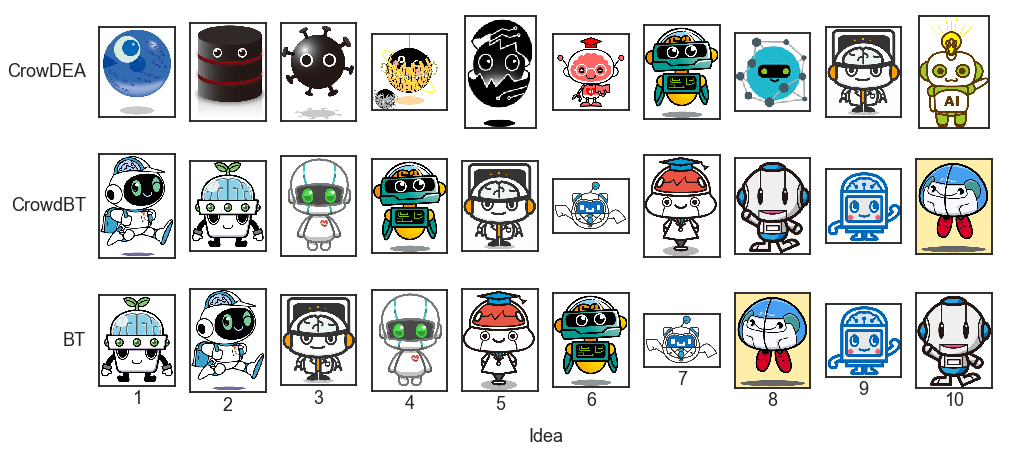

In [6]:
plot_ranking('ai_character')

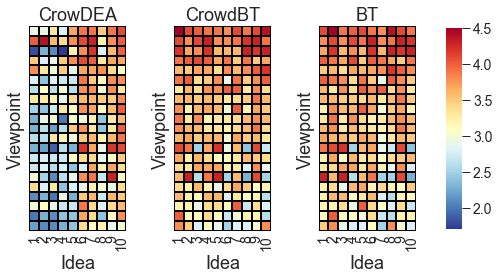

In [7]:
plot_heatmap('ai_character')

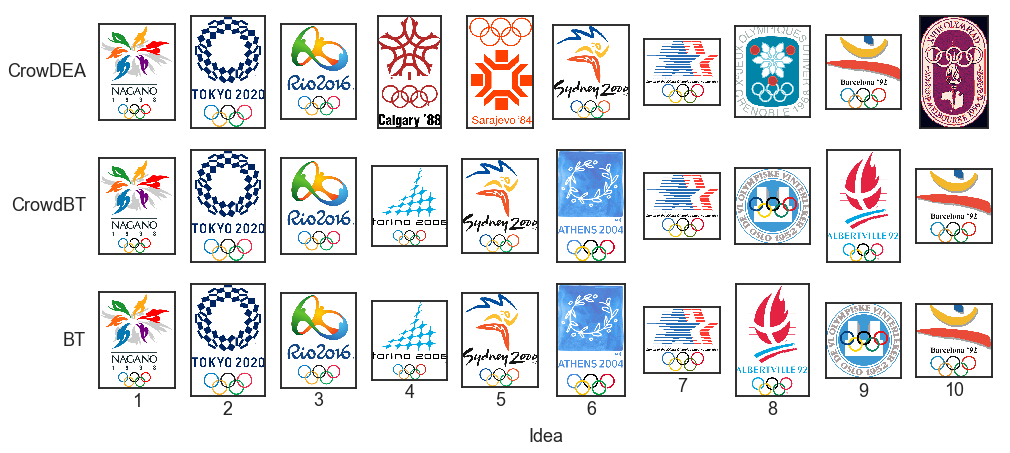

In [8]:
plot_ranking('olympic')

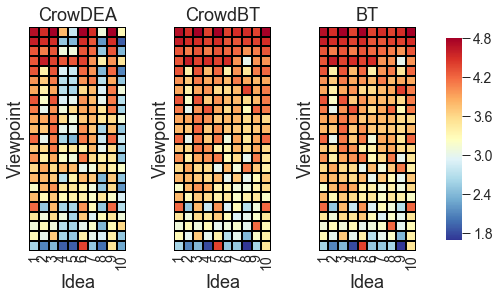

In [9]:
plot_heatmap('olympic')